# Basic Classification in TensorFlow 2.0 

## Learning Objectives

1. Build a model
2. Train this model on example data
3. Use the model to make predictions about unknown data

## Introduction

In this notebook, you use machine learning to *categorize* Iris flowers by species.  It uses TensorFlow to:

* Use TensorFlow's default eager execution development environment
* Import data with the Datasets API
* Build models and layers with TensorFlow's Keras API

Here firstly we will Import and parse the dataset, then select the type of model. After that Train the model.

At last we will Evaluate the model's effectiveness and then use the trained model to make predictions.


### Configure imports

Import TensorFlow and the other required Python modules.

In [1]:
# The OS module in python provides functions for interacting with the operating system
import os
# The matplotlib module provides all the fuctionalities for visualizing model
import matplotlib.pyplot as plt

In [2]:
# Here we'll import data processing libraries like tensorflow
import tensorflow as tf

2023-10-16 04:17:14.810646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 04:17:16.310354: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-16 04:17:16.310504: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## The Iris classification problem

Imagine you are a botanist seeking an automated way to categorize each Iris flower you find. Machine learning provides many algorithms to classify flowers statistically. 

## Import and parse the training dataset

Download the dataset file and convert it into a structure that can be used by this Python program.

### Download the dataset



In [3]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

# Download the training dataset file using the `tf.keras.utils.get_file` function. This returns the file path of the downloaded file.
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/jupyter/.keras/datasets/iris_training.csv


### Inspect the data

This dataset, `iris_training.csv`, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Use the `head -n5` command to take a peek at the first five entries:

In [4]:
# Output the first five rows
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [5]:
# Column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

# Let's output the value of `Features` and `Label`
print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [6]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### Create a `tf.data.Dataset`

In [7]:
batch_size = 32

# The `tf.data.experimental.make_csv_dataset()` method reads CSV files into a dataset
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

2023-10-16 04:17:21.123665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-16 04:17:21.123722: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-16 04:17:21.123754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (79649f733192): /proc/driver/nvidia/version does not exist
2023-10-16 04:17:21.124354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

To simplify the model building step, create a function to repackage the features dictionary into a single array with shape: `(batch_size, num_features)`.

This function uses the `tf.stack` method which takes values from a list of tensors and creates a combined tensor at the specified dimension:

In [8]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
# Using `tf.stack` we can stack a list of rank-R tensors into one rank-(R+1) tensor.
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

Then use the `tf.data.Dataset#map` method to pack the `features` of each `(features,label)` pair into the training dataset:

In [9]:
# The `map()` method will pack the `features` into the training dataset:
train_dataset = train_dataset.map(pack_features_vector)

The features element of the `Dataset` are now arrays with shape `(batch_size, num_features)`. Let's look at the first few examples:

### Create a model using Keras

The TensorFlow `tf.keras` API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

The `tf.keras.Sequential` model is a linear stack of layers. Its constructor takes a list of layer instances

In [10]:
#1
# Here `tf.keras.Sequential` used to sequentially groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
# `tf.keras.layers.Dense` is inherited from: `Layer`
# `tf.keras.layers.Dense` is your regular densely-connected NN layer.
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

## Train the model

### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's loss. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the `tf.keras.losses.SparseCategoricalCrossentropy` function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

In [12]:
# `tf.keras.losses.SparseCategoricalCrossentropy()` will computes the crossentropy loss between the labels and predictions.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [13]:
def loss(model, x, y, training):
  #2
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)


#l = loss(model, features, labels, training=False)
#print("Loss test: {}".format(l))

Use the `tf.GradientTape` context to calculate the [gradients](https://developers.google.com/machine-learning/crash-course/glossary#gradient) used to optimize your model:

In [14]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

Let's setup the optimizer:

In [16]:
# `tf.keras.optimizers.SGD()` will Gradient descent (with momentum) optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an `optimizer` to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `num_epochs` variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. `num_epochs` is a hyperparameter that you can tune. Choosing the right number usually requires both experience and experimentation:

In [17]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.979, Accuracy: 69.167%
Epoch 050: Loss: 0.414, Accuracy: 77.500%
Epoch 100: Loss: 0.315, Accuracy: 94.167%
Epoch 150: Loss: 0.221, Accuracy: 95.833%
Epoch 200: Loss: 0.154, Accuracy: 97.500%


### Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often *more* helpful to see this progress. [TensorBoard](https://www.tensorflow.org/tensorboard) is a nice visualization tool that is packaged with TensorFlow, but we can create basic charts using the `matplotlib` module.

Interpreting these charts takes some experience, but you really want to see the *loss* go down and the *accuracy* go up:

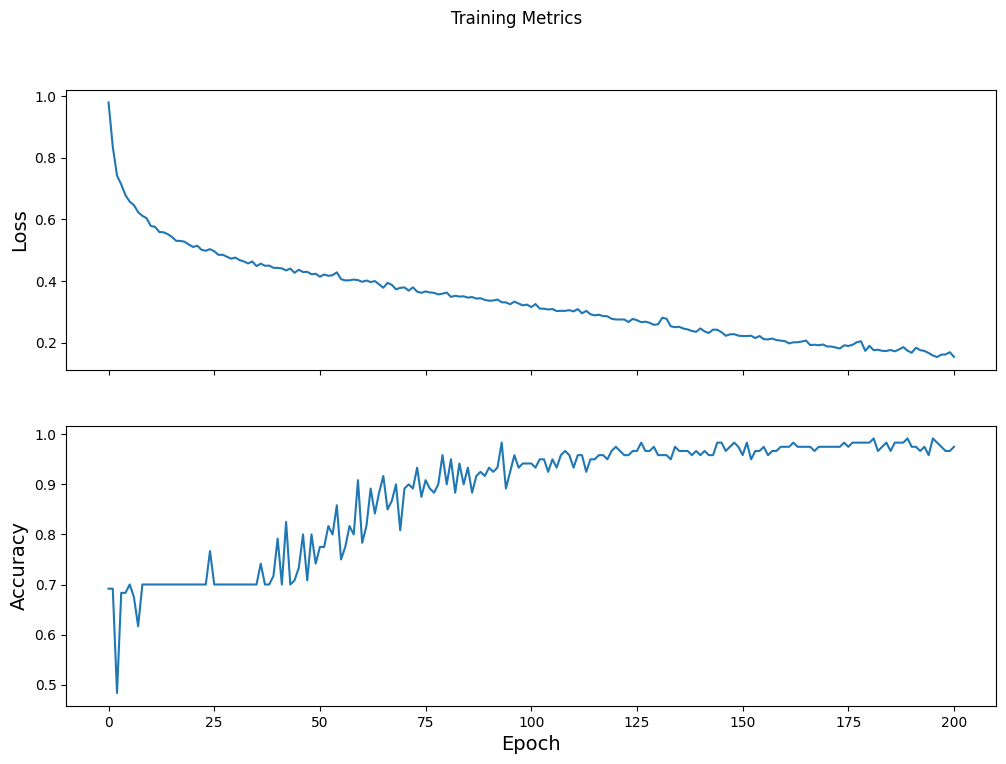

In [18]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
# `plt.show()` will display a figure
plt.show()

## Evaluate the model's effectiveness

### Setup the test dataset

In [19]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

# The `tf.keras.utils.get_file` will downloads a file from a URL if it not already in the cache.
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

In [20]:
# The `tf.data.experimental.make_csv_dataset()` method reads CSV files into a dataset
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

# The `map()` method will pack the `features` into the training dataset:
test_dataset = test_dataset.map(pack_features_vector)

### Evaluate the model on the test dataset

In [21]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


We can see on the last batch, for example, the model is usually correct:

In [22]:
# Using `tf.stack` we can stack a list of rank-R tensors into one rank-(R+1) tensor.
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

## Use the trained model to make predictions

In [23]:
#3
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
predictions = model(predict_dataset, training=False)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (98.7%)
Example 1 prediction: Iris versicolor (87.3%)
Example 2 prediction: Iris virginica (66.0%)
